In [1]:
# Made from Dillon's parent notebook 2022 Aug 25 by E.S.

In [1]:
import os
from os import listdir
from os.path import isfile,join
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits

In [2]:
#This is just setting up my filepaths; you should replace them with wherever your folders are

stem = "/Users/bandari/Documents/git.repos/gpi2_misc/data/"
path_low_flats = stem + "Pupil_Plane_Images/Low_Gain/Flats_(65_FPS)/"
path_low_darks = stem + "Pupil_Plane_Images/Low_Gain/Darks_(FPS)/"
path_low_lin = stem + "Pupil_Plane_Images/Low_Gain/Linearity_images_(FPS)/"

'''
darks_folders = sorted(listdir(path_low_darks), key = lambda x: int(os.path.splitext(x)[0]))
lin_folders = sorted(listdir(path_low_lin), key = lambda x: int(os.path.splitext(x)[0]))
'''

flat_files = glob.glob(path_low_flats + "*.raw")
dirs_darks_list = glob.glob(path_low_darks + "*[0-9]")
darks_folders = [os.path.basename(i) for i in dirs_darks_list]

'''
print (darks_folders)
print (lin_folders)
print (flat_files)
'''

'\nprint (darks_folders)\nprint (lin_folders)\nprint (flat_files)\n'

In [84]:
# sorted list of integration times

cadence_array = np.sort(np.array(darks_folders).astype(int))
exp_time_array = np.divide(1.,cadence_array)

In [9]:
cadence_array

array([ 35,  45,  55,  65,  75,  85,  95, 105, 115, 125, 135, 145, 155,
       165, 175, 185, 195, 205, 215, 225])

## Creating Master Dark frames for each exposure time

In [6]:
#This code just runs through the files in each folder for the darks, and creates a master dark for each FPS

array_list_darks = []     # This is the final output of this block

# loop over integration times
for int_num in range(0,len(exp_time_array)):
        
    folder_path = path_low_darks + str(exp_time_array[int_num]) # folders
    filenames = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    temp_array_list = []
    
    # loop over frames at single integration time
    for frames in filenames:
    
        img_file = folder_path + '/' + frames
        arraytype = np.fromfile(img_file, dtype = np.int16)
        arraytype.shape = (512, 640)
        temp_array_list.append(arraytype)
                
    # stdevs and mean/median of frames at given integration time
    std_dark = np.std(temp_array_list, axis = 0) 
    mean_dark = np.mean(temp_array_list, axis = 0)    #Can change this to median if wanted
        
    # add net frame to stack of darks
    array_list_darks.append(mean_dark)

# We now have array_list_darks, which is a list of master dark arrays from 35 to 225 FPS (20) created by MEAN
# A quick look at one of the darks

'''
dark_plot = plt.figure()
dark_plot.add_axes()
plt.title('Dark for Low-Gain Darks [11]')
plt.xlabel('Columns')
plt.ylabel('Rows')
dark_plot = plt.imshow(array_list_darks[11], cmap = 'viridis', interpolation = 'nearest', origin="lower")
plt.colorbar(dark_plot)
plt.clim(400, 1200)

plt.show(dark_plot)
print (np.mean(array_list_darks[11]))
print (np.std(array_list_darks[11]))

#They really all look the same
'''

'\ndark_plot = plt.figure()\ndark_plot.add_axes()\nplt.title(\'Dark for Low-Gain Darks [11]\')\nplt.xlabel(\'Columns\')\nplt.ylabel(\'Rows\')\ndark_plot = plt.imshow(array_list_darks[11], cmap = \'viridis\', interpolation = \'nearest\', origin="lower")\nplt.colorbar(dark_plot)\nplt.clim(400, 1200)\n\nplt.show(dark_plot)\nprint (np.mean(array_list_darks[11]))\nprint (np.std(array_list_darks[11]))\n\n#They really all look the same\n'

In [48]:
# save as 3D FITS file
#hdu = fits.PrimaryHDU(temp_array_list)
hdu = fits.PrimaryHDU(array_list_darks)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_darks_3d.fits', overwrite=True)

In [10]:
array_list_darks[3]

array([[-6742.5 ,    10.  ,     0.  , ...,   263.28,   303.84,   338.74],
       [  605.66,   773.72,   644.16, ...,   865.04,   956.34,   859.46],
       [  713.74,   726.64,   862.02, ...,   907.1 ,   852.7 ,   699.88],
       ...,
       [  684.  ,   766.68,   761.72, ...,   968.38,   924.66,   867.34],
       [  704.74,   736.62,   706.8 , ...,   935.62,   797.16,   774.54],
       [  586.54,   721.52,   680.94, ...,   791.9 ,   896.72,   877.6 ]])

## Creating the Master Flat for 65 FPS

/Users/bandari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


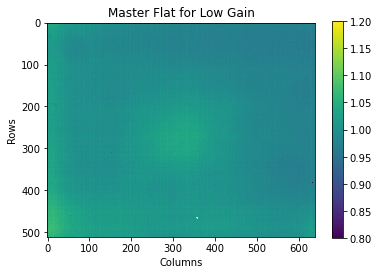

0.9999999999999998
0.020141689087780835


In [13]:
#This code just creates a master flat (dark subtracted), and then normalizes it
master_flat_array = []

# loop over all flats at 65 FPS
for frames in flat_files:
    
    img_file = frames
    arraytype = np.fromfile(img_file, dtype = np.int16)
    arraytype.shape = (512, 640)
    
    # subtract dark
    arraytype = np.subtract(arraytype,array_list_darks[3])        #Subtracting the darks of the corresponding FPS (65)
    master_flat_array.append(arraytype)

# average the dark-subtracted flats
master_flat = np.mean(master_flat_array, axis = 0)     #Can change this to MEDIAN if wanted
master_flat = np.divide(master_flat,np.mean(master_flat))
# We now have a master flat frame, with darks subtracted and then AVERAGED

flat_plot = plt.figure()
flat_plot.add_axes()
plt.title('Master Flat for Low Gain')
plt.xlabel('Columns')
plt.ylabel('Rows')
flat_plot = plt.imshow(master_flat, cmap = 'viridis', interpolation = 'nearest')
plt.colorbar(flat_plot)
plt.clim(0.8, 1.2)

plt.show(flat_plot)
print (np.mean(master_flat))
print (np.std(master_flat))

In [47]:
# save net frame as 3D FITS file

hdu = fits.PrimaryHDU(master_flat_array)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_flat_3d.fits', overwrite=True)

In [14]:
# save net frame as FITS file

hdu = fits.PrimaryHDU(master_flat)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_flat.fits', overwrite=True)

In [15]:
lin_folders

NameError: name 'lin_folders' is not defined

## Reducing the "Science" Images

In [73]:
#This reduces the combined science images of each FPS with the darks of each respective FPS, and then divides by the
#master flat. It also records the mean and variances of each final science image to make a rudimentary gain plot

array_list_lin = []     # This is the final output of this block

mean_list = []
variance_list = []

# loop over integration times
for int_num in range(0,len(exp_time_array)):
    
    folder_path = path_low_lin + str(exp_time_array[int_num]) # folders
    filenames = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    print(filenames)
    print(exp_time_array[int_num])
    
    temp_array_list = []
    
    # loop over 'science' frames at this integration time
    for frames in filenames:
    
        img_file = folder_path + '/' + frames
        arraytype = np.fromfile(img_file, dtype = np.int16)
        arraytype.shape = (512, 640)
        temp_array_list.append(arraytype)
        
    # save cube of frames at this integration time to check
    hdu = fits.PrimaryHDU(temp_array_list)
    hdul = fits.HDUList([hdu])
    hdul.writeto("junk_"+str(exp_time_array[int_num])+".fits", overwrite=True)
        
    # make net frame for this integration time
    mean_lin = np.mean(temp_array_list, axis = 0)    #Can change this to median if wanted
    
    #Doing the reduction in this step, replacing divide by 0s with 0s
    
    # subtract dark
    sci_minus_dark = np.subtract(mean_lin,array_list_darks[int_num])
    # divide by flat
    final_lin = np.divide(sci_minus_dark, master_flat)
    
    idx_finite = np.isfinite(final_lin)
    mean_list.append(np.nanmean(final_lin[idx_finite]))
    variance_list.append(np.power(np.nanstd(final_lin[idx_finite]),2.0))
    
    # stack together frames at different integration times
    array_list_lin.append(final_lin)

['frame882967.raw', 'frame882966.raw', 'frame882958.raw', 'frame882964.raw', 'frame882970.raw', 'frame882965.raw', 'frame882959.raw', 'frame882961.raw', 'frame882949.raw', 'frame882948.raw', 'frame882960.raw', 'frame882962.raw', 'frame882963.raw', 'frame882938.raw', 'frame882939.raw', 'frame882929.raw', 'frame882928.raw', 'frame882931.raw', 'frame882925.raw', 'frame882924.raw', 'frame882930.raw', 'frame882926.raw', 'frame882932.raw', 'frame882933.raw', 'frame882927.raw', 'frame882923.raw', 'frame882937.raw', 'frame882936.raw', 'frame882922.raw', 'frame882934.raw', 'frame882921.raw', 'frame882935.raw', 'frame882952.raw', 'frame882946.raw', 'frame882947.raw', 'frame882953.raw', 'frame882945.raw', 'frame882951.raw', 'frame882950.raw', 'frame882944.raw', 'frame882940.raw', 'frame882954.raw', 'frame882968.raw', 'frame882969.raw', 'frame882955.raw', 'frame882941.raw', 'frame882957.raw', 'frame882943.raw', 'frame882942.raw', 'frame882956.raw']
35


/Users/bandari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/bandari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


['frame884537.raw', 'frame884523.raw', 'frame884494.raw', 'frame884495.raw', 'frame884522.raw', 'frame884536.raw', 'frame884520.raw', 'frame884534.raw', 'frame884508.raw', 'frame884497.raw', 'frame884496.raw', 'frame884509.raw', 'frame884535.raw', 'frame884521.raw', 'frame884519.raw', 'frame884525.raw', 'frame884531.raw', 'frame884492.raw', 'frame884493.raw', 'frame884530.raw', 'frame884524.raw', 'frame884518.raw', 'frame884532.raw', 'frame884526.raw', 'frame884491.raw', 'frame884490.raw', 'frame884527.raw', 'frame884533.raw', 'frame884516.raw', 'frame884502.raw', 'frame884489.raw', 'frame884503.raw', 'frame884517.raw', 'frame884501.raw', 'frame884515.raw', 'frame884529.raw', 'frame884528.raw', 'frame884514.raw', 'frame884500.raw', 'frame884538.raw', 'frame884504.raw', 'frame884510.raw', 'frame884511.raw', 'frame884505.raw', 'frame884513.raw', 'frame884507.raw', 'frame884498.raw', 'frame884499.raw', 'frame884506.raw', 'frame884512.raw']
45
['frame886848.raw', 'frame886849.raw', 'frame8

['frame914848.raw', 'frame914849.raw', 'frame914812.raw', 'frame914806.raw', 'frame914807.raw', 'frame914813.raw', 'frame914839.raw', 'frame914805.raw', 'frame914811.raw', 'frame914810.raw', 'frame914804.raw', 'frame914838.raw', 'frame914800.raw', 'frame914814.raw', 'frame914828.raw', 'frame914829.raw', 'frame914815.raw', 'frame914801.raw', 'frame914817.raw', 'frame914803.raw', 'frame914802.raw', 'frame914816.raw', 'frame914833.raw', 'frame914827.raw', 'frame914826.raw', 'frame914832.raw', 'frame914818.raw', 'frame914824.raw', 'frame914830.raw', 'frame914831.raw', 'frame914825.raw', 'frame914819.raw', 'frame914821.raw', 'frame914835.raw', 'frame914809.raw', 'frame914808.raw', 'frame914834.raw', 'frame914820.raw', 'frame914836.raw', 'frame914822.raw', 'frame914823.raw', 'frame914837.raw', 'frame914844.raw', 'frame914845.raw', 'frame914847.raw', 'frame914846.raw', 'frame914842.raw', 'frame914843.raw', 'frame914841.raw', 'frame914840.raw']
135
['frame920241.raw', 'frame920240.raw', 'frame

['frame967368.raw', 'frame967354.raw', 'frame967383.raw', 'frame967397.raw', 'frame967396.raw', 'frame967382.raw', 'frame967355.raw', 'frame967369.raw', 'frame967357.raw', 'frame967394.raw', 'frame967380.raw', 'frame967381.raw', 'frame967395.raw', 'frame967356.raw', 'frame967352.raw', 'frame967391.raw', 'frame967385.raw', 'frame967384.raw', 'frame967390.raw', 'frame967353.raw', 'frame967351.raw', 'frame967379.raw', 'frame967386.raw', 'frame967392.raw', 'frame967393.raw', 'frame967387.raw', 'frame967378.raw', 'frame967350.raw', 'frame967349.raw', 'frame967361.raw', 'frame967375.raw', 'frame967374.raw', 'frame967360.raw', 'frame967348.raw', 'frame967376.raw', 'frame967362.raw', 'frame967389.raw', 'frame967388.raw', 'frame967363.raw', 'frame967377.raw', 'frame967373.raw', 'frame967367.raw', 'frame967366.raw', 'frame967372.raw', 'frame967364.raw', 'frame967370.raw', 'frame967358.raw', 'frame967359.raw', 'frame967371.raw', 'frame967365.raw']
225


In [79]:
mean_list

[14121.425066852773,
 10958.244087289535,
 8973.723816480557,
 7589.985348371183,
 6582.642286526186,
 5792.716722059446,
 5154.574887447866,
 4650.483303078214,
 4244.38894675383,
 3897.689957485157,
 3600.1036317000357,
 3352.0718772210785,
 3133.481669109377,
 2944.538833768069,
 2772.4404660772343,
 2624.8079721744807,
 2487.322081263779,
 2365.7003930024734,
 2251.4339352539046,
 2149.5643102630743]

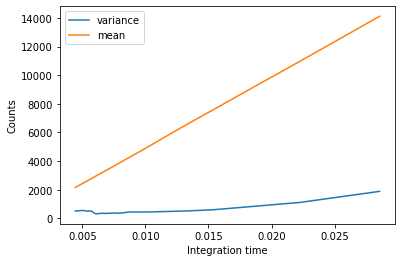

In [85]:
plt.xlabel("Integration time")
plt.ylabel("Counts")
plt.plot(exp_time_array,variance_list,label="variance")
plt.plot(exp_time_array,mean_list,label="mean")
plt.legend()
plt.savefig("test_plot.pdf")

In [81]:
# save as 3D FITS file
#hdu = fits.PrimaryHDU(temp_array_list)
hdu = fits.PrimaryHDU(array_list_lin)
hdul = fits.HDUList([hdu])
hdul.writeto('junk.fits', overwrite=True)

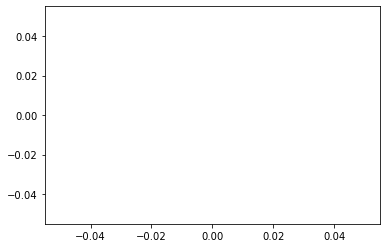

In [49]:
plt.scatter(exp_time_array, variance_list)

In [81]:
#Calculates a linear fit for the slope
equation_fit = np.polyfit(mean_list, variance_list, 1)
print (equation_fit)

print ('The gain is the inverse of the slope, which gives us ' + str(1.0 / equation_fit[0]))

[ 2.29268077e-01 -2.47161200e+02]
The gain is the inverse of the slope, which gives us 4.361706234177038


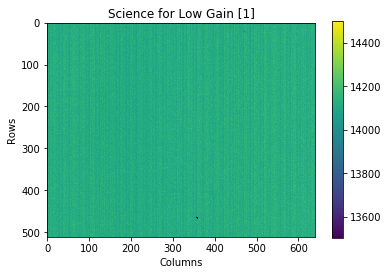

In [82]:
#Just looking at one of the science images (reduced)
lin_plot = plt.figure()
lin_plot.add_axes()
plt.title('Science for Low Gain [1]')
plt.xlabel('Columns')
plt.ylabel('Rows')
lin_plot = plt.imshow(array_list_lin[0], cmap = 'viridis', interpolation = 'nearest')
plt.colorbar(lin_plot)
plt.clim(13500, 14500)

plt.show(lin_plot)